# 5 深度学习计算

## 5.1 层和块

#### 层

- 接受一些输入
- 生成相应的标量输出
- 具有一组相关参数

本质上即是单独的一整层神经元。

#### 块

**块（block）** 可以描述单个层、由多个层组成的组件或整个模型本身，是一种抽象化的代指方法。

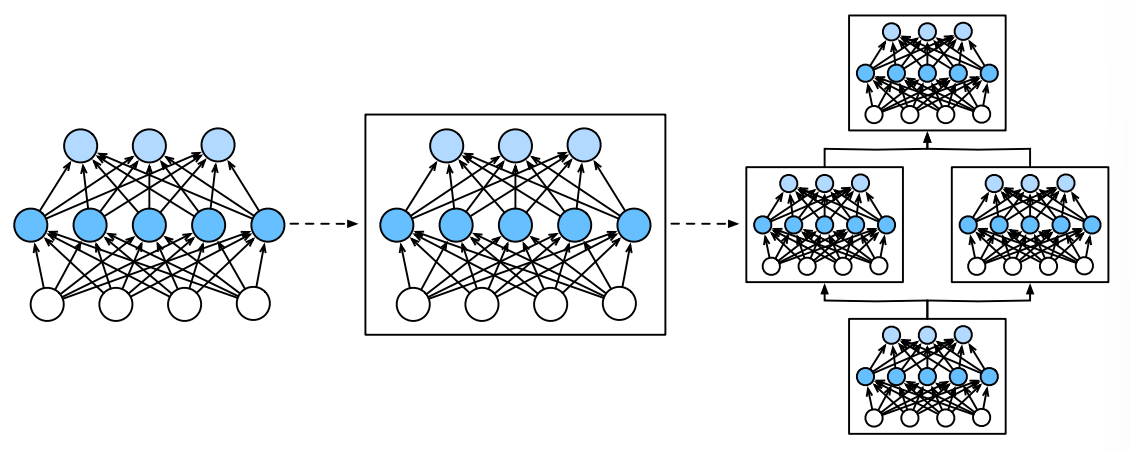

从编程的角度来看，块由类（class）表示。它的任何子类都必须定义一个将其输入转换为输出的前向传播函数，并且必须存储任何必需的参数，最后为了计算梯度还必须具有反向传播函数。

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256) # 隐藏层
        self.out = nn.Linear(256, 10) # 输出层
    
    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

深度学习框架通过自动计算导数，即 **自动微分（automatic differentiation）** 来加快求导：

1.  Pytorch中的 `backward()` 函数是自动微分的核心函数：

In [5]:
z = x * y + x**2

z.backward() # 计算梯度

x.grad # 获取 dz/dx
y.grad # 获取 dz/dy

NameError: name 'x' is not defined

自动微分本质上通过分解复杂函数为基本运算，利用链式法则递归计算梯度，它通过构建计算图记录所有操作步骤，反向遍历图计算梯度。 `backward()` 默认只保存叶子节点（用户直接创建）的梯度。

2. Pytorch默认会 **累加梯度** ，必须手动清零避免累积影响，使用 `.grad.zero_()` 函数。

In [ ]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

#### 顺序块

`nn.Sequential` 定义了一种特殊的Module，即在PyTorch中表示一个块的类，它维护了一个由Module组成的有序列表。

Sequential类使模型构造变得简单，允许我们组合新的架构，而不必定义自己的类。



In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[ 0.0894, -0.0101,  0.0903, -0.0468,  0.1084,  0.4318, -0.0872, -0.0863,
         -0.0043,  0.0353],
        [ 0.1574, -0.0499,  0.0461, -0.0646,  0.1717,  0.2948, -0.0755, -0.2517,
          0.0761, -0.0636]], grad_fn=<AddmmBackward0>)

## 5.2 参数管理

In [ ]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.4899],
        [0.5295]], grad_fn=<AddmmBackward0>)

当通过 Sequential 类定义模型时，我们可以通过索引来访问模型的任意层，此时模型如同列表，每层的参数都在其属性中：

#### state_dict()

`state_dict()` 是 Pytorch 中获取模型状态字典的核心函数，它返回一个有序字典，包含权重、偏置等可训练参数。

In [ ]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.0780,  0.0506,  0.3354,  0.0116,  0.3143, -0.1898, -0.1143,  0.0712]])), ('bias', tensor([0.2757]))])


#### bias, weight, weight.grad

每个参数都表示为参数类的一个实例。索引后面以访问参数的方式调用参数。

参数是复合的对象，包含值、梯度和额外信息。除了值之外，还可以访问每个参数的梯度。当没有调用反向传播时，参数的梯度处于初始状态。

In [ ]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.2757], requires_grad=True)
tensor([0.2757])


In [ ]:
net[2].weight.grad == None

True

#### 一次性访问所有参数

当需要对所有参数执行操作时，逐个访问会很麻烦。因此我们需要递归整个树来提取每个子块的参数。

下面比较访问第一个全连接层的参数和访问所有层：

In [ ]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


*注：之所以是 0 和 2 层，是因为1层是 **隐藏层** ，参见 第4章。隐藏层施加非线性的激活函数，如以下的模型定义中第1层施加了ReLU函数。*

```python
model = nn.Sequential(
    nn.Linear(10, 20),  # 第0层
    nn.ReLU(),           # 第1层
    nn.Linear(20, 5)     # 第2层
)
```

## 5.3 参数初始化

#### 内置初始化器：nn.init

- `nn.init.normal_`：

    `nn.init.normal_(linear.weight, mean=0.0, std=0.02)` ，使用正态分布初始化权重，均值为0，标准差为0.02
    
- `nn.init.zeros_`：

    `nn.init.zeros_(linear.bias)` ，初始化偏置为0

- `nn.init.constant_`：

    `nn.init.constant_(linear.bias, 0.1)` ，将输入张量的所有元素设置为指定的常量值，如初始化偏置为0.1

- `nn.init.uniform_`：

    `nn.init.uniform_(linear.weight, a=-0.1, b=0.1)` ，将输入张量的元素初始化为指定区间 [a, b] 内均匀分布的随机值

- `nn.init.xavier_uniform_`：

    `nn.init.xavier_uniform_(m.weight)` ，使用Xavier初始化方法（见4.6）


#### 自定义初始化

#### 参数绑定

当希望在多个层间共享参数时，可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。

In [ ]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), shared, nn.ReLU(), shared, nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


*注：当任意层的输入维度没有指定时，无法在初始化参数时确定模型应该包括多少参数，但是可以使用 **延后初始化（Deferred Initialization）** 机制，即模型参数的实际创建和初始化被推迟到第一次前向传播时进行，而非在模型定义时立即执行。*

## 5.4 读写文件与GPU

#### 加载和保存单个张量

- `torch.save()` ：

    PyTorch 中用于序列化保存模型、张量或任意 Python 对象的核心函数。

    参数如下：
    ```python
    torch.save(
    obj,                    # 要保存的对象（模型/张量/字典）
    f,                      # 文件路径或文件对象
    pickle_module=pickle,   # 序列化模块（默认pickle）
    pickle_protocol=2,      # pickle协议版本
    _use_new_zipfile_serialization=True  # 使用新的zip序列化格式
    )
    ```
    

- `torch.load()` ：

    PyTorch 中用于 加载由 torch.save() 保存的模型、张量或任意 Python 对象的核心函数。

    参数如下：
    ```python
    torch.load(
    f,                      # 文件路径或文件对象
    map_location=None,       # 设备映射设置
    pickle_module=pickle,    # 反序列化模块
    **pickle_load_args      # 传递给pickle的额外参数
    )
    ```

#### 加载和保存模型

保存模型的参数而不是保存整个模型。为了恢复模型，我们需要用代码生成架构，然后从磁盘加载参数。

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)
    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))
    
net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

torch.save(net.state_dict(), 'mlp.params')

clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

1. `net.state_dict()` ：获取模型当前的状态字典，返回一个有序字典，包含：

    ```python
    {
    'hidden.weight': 张量(256×20),
    'hidden.bias': 张量(256),
    'output.weight': 张量(10×256),
    'output.bias': 张量(10)
    }
    ```

2. `clone = MLP()` ：创建新的空白模型实例

3. `clone.load_state_dict(torch.load('mlp.params'))` ：从文件中加载保存的状态字典，将加载的字典复制到新模型的参数中

4. `clone.eval()` ：将模型设为评估模式

*注：在PyTorch中，将模型设置为评估模式（通过调用 .eval()方法）是进行推理（inference）或评估（evaluation）时的关键步骤，这主要影响模型中的 特殊层在训练和推理时的不同行为。*

*1. 训练模式下Dropout层按概率p随机丢弃神经元，评估模式下使Dropout层停止丢弃，所有神经元都参与计算*

*2. 使用当前批次的均值和方差进行归一化，使用训练过程中累积的全局均值和方差*

#### GPU

在PyTorch中，每个数组都有一个设备（device），我们通常将其称为环境（context）。默认情况下，所有变量和相关的计算都分配给CPU。

- 在PyTorch中，CPU和GPU可以用 `torch.device('cpu')` 和 `torch.device('cuda')` 表示

- 通过 `x.device` （x是张量）可以查询张量所在的设备。默认情况下，张量是在CPU上创建的

- 无论何时我们要对多个项进行操作，它们都 **必须在同一个设备上** 

- 在任意创建张量的函数，如 `torch.ones()` 和 `torch.rand()` 等，通过设置参数 `device` 可以指定设备创建张量



In [10]:
def try_gpu(i=0): #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus(): #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
        for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

X = torch.ones(2, 3, device=try_gpu())

Y = torch.rand(2, 3, device=try_gpu(1))

X.device,Y.device

(device(type='cpu'), device(type='cpu'))